In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
#import sklearn
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "/home/mx19/datasets/hot-dog-not-hot-dog/"
print("The data lies here =>", root_dir)

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

hotdog_dataset = datasets.ImageFolder(root = root_dir + "train",
                                      transform = image_transforms["train"]
                                     )

print(hotdog_dataset)
print(hotdog_dataset.class_to_idx)


We're using => cuda
The data lies here => /home/mx19/datasets/hot-dog-not-hot-dog/
Dataset ImageFolder
    Number of datapoints: 498
    Root location: /home/mx19/datasets/hot-dog-not-hot-dog/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
{'hot_dog': 0, 'not_hot_dog': 1}


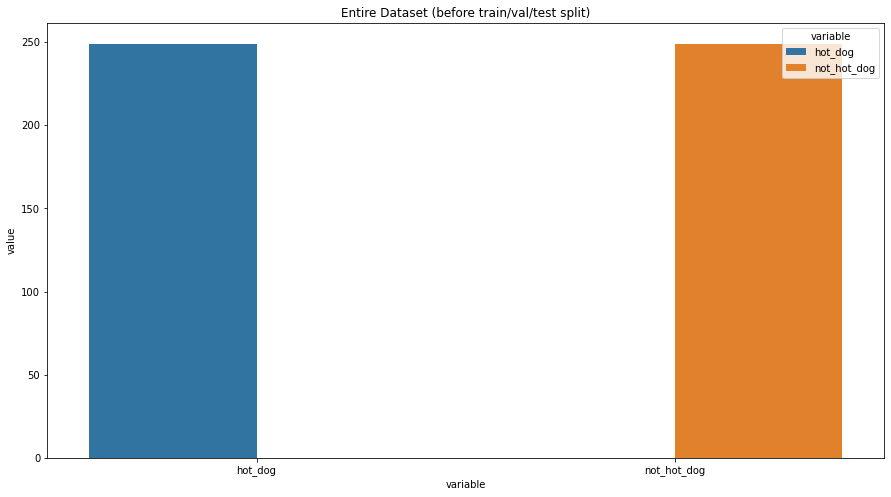

In [3]:
idx2class = {v: k for k, v in hotdog_dataset.class_to_idx.items()}

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(hotdog_dataset), plot_title="Entire Dataset (before train/val/test split)")
plt.show()


train_split_index 99
val_split_index 473


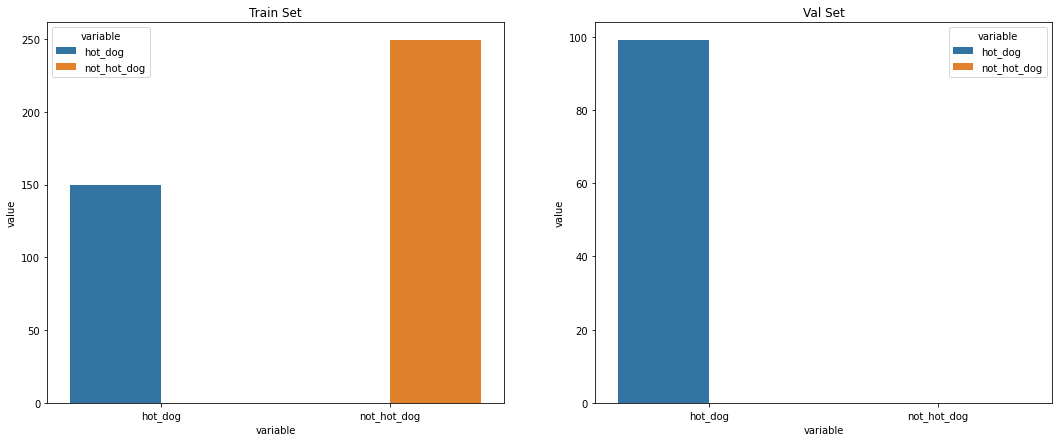

In [4]:
###########################
##### TEST

##Now that we’re done with train and val data, let’s load our test dataset.

hotdog_dataset_size = len(hotdog_dataset)
hotdog_dataset_indices = list(range(hotdog_dataset_size))
train_split_index = int(np.floor(0.2 * hotdog_dataset_size))
val_split_index = int(np.floor(0.95 * hotdog_dataset_size))
print(f'train_split_index {train_split_index}')
print(f'val_split_index {val_split_index}')

train_idx = hotdog_dataset_indices[train_split_index:]
val_idx = hotdog_dataset_indices[:train_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
#print(f'train_idx {train_idx}')
#print(f'val_idx {val_idx}')


hotdog_dataset_test = datasets.ImageFolder(root = root_dir + "test",
                                            transform = image_transforms["test"]
                                           )

train_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=hotdog_dataset_test, shuffle=False, batch_size=1)
#print(hotdog_dataset_test)
#print(train_loader.dataset)
#print(val_loader.dataset)

def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else:
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict


#print(get_class_distribution_loaders(train_loader, hotdog_dataset))
#print(get_class_distribution_loaders(val_loader, hotdog_dataset))
#print(get_class_distribution_loaders(test_loader, hotdog_dataset))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, hotdog_dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, hotdog_dataset), plot_title="Val Set", ax=axes[1])
plt.show()


torch.Size([8, 3, 224, 224])
Output label tensors:  tensor([1, 1, 0, 1, 0, 1, 1, 0])

Output label tensor shape:  torch.Size([8])
torch.Size([3, 224, 224])


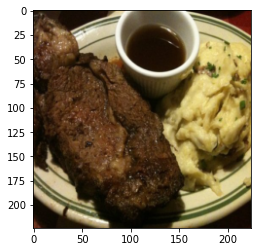

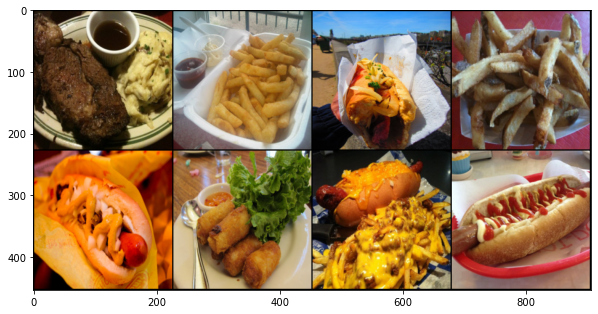

In [5]:
single_batch = next(iter(train_loader))
print(single_batch[0].shape)

print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)


# Selecting the first image tensor from the batch.
single_image = single_batch[0][0]
print(single_image.shape)
plt.imshow(single_image.cpu().detach().numpy().transpose((1, 2, 0)))
plt.show()

# We do single_batch[0] because each batch is a list
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))
plt.show()


In [6]:
class HotDogClassifier(nn.Module):
    def __init__(self):
        super(HotDogClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x

    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block


model = HotDogClassifier()
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)



HotDogClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [7]:


# function to calculate accuracy per epoch.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc


#We’ll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}


In [8]:
###################
## Let’s TRAIN our model!


print("Begin training.")
epoch_number = 21

for e in tqdm(range(1, epoch_number)):

    ## TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    ## VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
            loss_stats['val'].append(val_epoch_loss/len(val_loader))

            accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
            accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
            
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    print(f'Epoch {e+0:02}:' )

Begin training.


  0%|                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]/home/mx19/anaconda3/envs/codeVE/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  5%|███████▋                                                                                                                                                  | 1/20 [00:06<02:11,  6.94s/it]

Epoch 01: | Train Loss: 98.48344 | Val Loss: 554.31824 | Train Acc: 60.080| Val Acc: 2.020
Epoch 01:


 10%|███████████████▍                                                                                                                                          | 2/20 [00:12<01:51,  6.17s/it]

Epoch 02: | Train Loss: 57.14531 | Val Loss: 128.04862 | Train Acc: 63.620| Val Acc: 26.263
Epoch 02:


 15%|███████████████████████                                                                                                                                   | 3/20 [00:18<01:41,  5.97s/it]

Epoch 03: | Train Loss: 25.41030 | Val Loss: 20.14613 | Train Acc: 72.380| Val Acc: 72.727
Epoch 03:


 20%|██████████████████████████████▊                                                                                                                           | 4/20 [00:23<01:33,  5.85s/it]

Epoch 04: | Train Loss: 14.68452 | Val Loss: 119.22169 | Train Acc: 75.880| Val Acc: 17.172
Epoch 04:


 25%|██████████████████████████████████████▌                                                                                                                   | 5/20 [00:29<01:26,  5.78s/it]

Epoch 05: | Train Loss: 7.44798 | Val Loss: 50.29379 | Train Acc: 84.260| Val Acc: 44.444
Epoch 05:


 30%|██████████████████████████████████████████████▏                                                                                                           | 6/20 [00:35<01:20,  5.75s/it]

Epoch 06: | Train Loss: 7.03943 | Val Loss: 78.93576 | Train Acc: 83.900| Val Acc: 22.222
Epoch 06:


 35%|█████████████████████████████████████████████████████▉                                                                                                    | 7/20 [00:41<01:14,  5.73s/it]

Epoch 07: | Train Loss: 4.47977 | Val Loss: 31.62504 | Train Acc: 87.920| Val Acc: 48.485
Epoch 07:


 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 8/20 [00:46<01:08,  5.75s/it]

Epoch 08: | Train Loss: 2.36835 | Val Loss: 10.10603 | Train Acc: 90.200| Val Acc: 76.768
Epoch 08:


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                    | 9/20 [00:52<01:03,  5.74s/it]

Epoch 09: | Train Loss: 1.85246 | Val Loss: 36.06573 | Train Acc: 92.040| Val Acc: 36.364
Epoch 09:


 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 10/20 [00:58<00:57,  5.75s/it]

Epoch 10: | Train Loss: 0.94029 | Val Loss: 47.41637 | Train Acc: 95.320| Val Acc: 27.273
Epoch 10:


 55%|████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 11/20 [01:03<00:51,  5.73s/it]

Epoch 11: | Train Loss: 1.71801 | Val Loss: 45.20039 | Train Acc: 92.860| Val Acc: 27.273
Epoch 11:


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12/20 [01:09<00:45,  5.72s/it]

Epoch 12: | Train Loss: 0.70798 | Val Loss: 44.27442 | Train Acc: 95.920| Val Acc: 33.333
Epoch 12:


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13/20 [01:15<00:39,  5.71s/it]

Epoch 13: | Train Loss: 0.40130 | Val Loss: 50.26014 | Train Acc: 97.840| Val Acc: 28.283
Epoch 13:


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 14/20 [01:21<00:34,  5.72s/it]

Epoch 14: | Train Loss: 0.62463 | Val Loss: 23.59992 | Train Acc: 96.880| Val Acc: 48.485
Epoch 14:


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 15/20 [01:26<00:28,  5.72s/it]

Epoch 15: | Train Loss: 1.05470 | Val Loss: 18.85295 | Train Acc: 92.820| Val Acc: 60.606
Epoch 15:


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 16/20 [01:32<00:22,  5.72s/it]

Epoch 16: | Train Loss: 0.51759 | Val Loss: 27.43398 | Train Acc: 96.740| Val Acc: 51.515
Epoch 16:


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 17/20 [01:38<00:17,  5.73s/it]

Epoch 17: | Train Loss: 1.22227 | Val Loss: 27.81643 | Train Acc: 94.620| Val Acc: 45.455
Epoch 17:


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 18/20 [01:44<00:11,  5.73s/it]

Epoch 18: | Train Loss: 1.41267 | Val Loss: 20.73060 | Train Acc: 93.840| Val Acc: 61.616
Epoch 18:


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 19/20 [01:49<00:05,  5.71s/it]

Epoch 19: | Train Loss: 1.99294 | Val Loss: 51.06202 | Train Acc: 90.280| Val Acc: 16.162
Epoch 19:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:55<00:00,  5.77s/it]

Epoch 20: | Train Loss: 0.44509 | Val Loss: 32.36314 | Train Acc: 95.640| Val Acc: 36.364
Epoch 20:


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

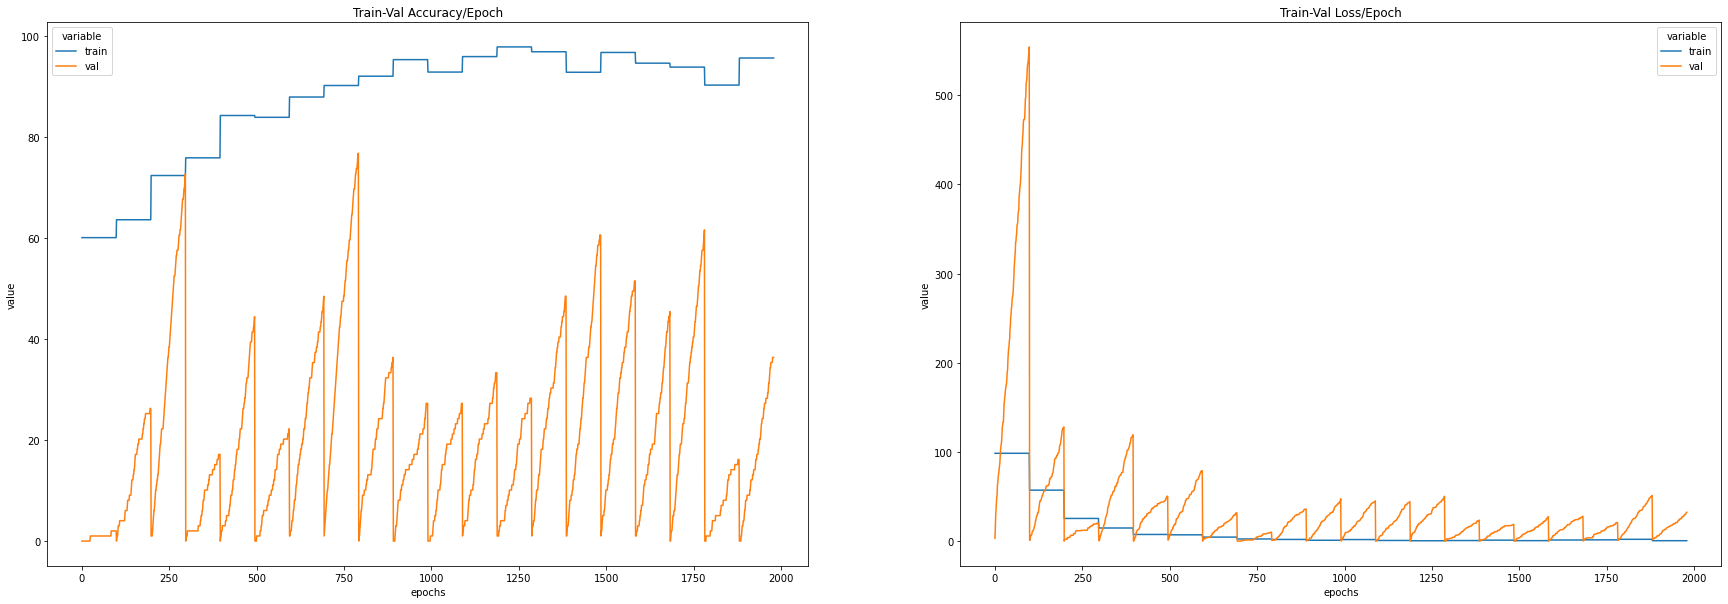

In [9]:
#Visualize Loss and Accuracy
#To plot the loss and accuracy line plots, we again create a dataframe from the accuracy_stats and 
#loss_stats dictionaries.

#print(len(accuracy_stats['train']))
#print(len(accuracy_stats['val']))
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# print((train_val_acc_df))

#print(len(loss_stats['train']))
#print(len(loss_stats['val']))
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
#print(train_val_loss_df)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')



In [10]:

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)        
        
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        

#We’ll flatten out the list so that we can use it as an input to confusion_matrix and classification_report.        
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]        



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 156.42it/s]


In [12]:

print(y_pred_list)
print(y_true_list)

print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))


[1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 

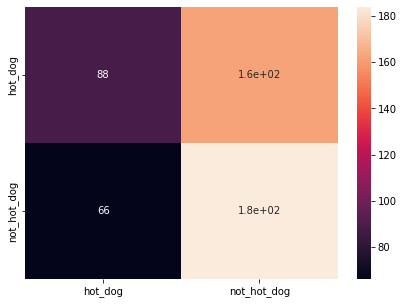

In [14]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
plt.show()